# Dealing with SketchRNN dataset

This time we'll have a look at _SketchRNN_ dataset and try to build an RNN that recognizes things sketched in those pictures.

The dataset is hanging somewhere between its [pull request](https://github.com/tensorflow/datasets/pull/361) and presence in TFDS, so we'll need to download it manually using proper link.

Since the data is being stored using protobuffs, a [proper description](https://github.com/tensorflow/tensorflow/blob/3862af9ca02547fcff41dc67bb520b69f494ba13/tensorflow/docs_src/tutorials/recurrent_quickdraw.md#optional-converting-the-data) is needed to decode it.

In [1]:
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

from IPython import display

np.random.seed(12)
tf.random.set_seed(12)

# Getting the data

In [2]:
filepath = keras.utils.get_file('quickdraw',
    'http://download.tensorflow.org/data/quickdraw_tutorial_dataset_v1.tar.gz',
    cache_dir=os.path.join(os.curdir, 'datasets'),
    cache_subdir='quickdraw',
    extract=True)

subdir = filepath[:-len('/quickdraw')]

1065312256/1065301781 [==============================] - 79s 0us/step


In [3]:
sorted(os.listdir(subdir))

['eval.tfrecord-00000-of-00010',
 'eval.tfrecord-00001-of-00010',
 'eval.tfrecord-00002-of-00010',
 'eval.tfrecord-00003-of-00010',
 'eval.tfrecord-00004-of-00010',
 'eval.tfrecord-00005-of-00010',
 'eval.tfrecord-00006-of-00010',
 'eval.tfrecord-00007-of-00010',
 'eval.tfrecord-00008-of-00010',
 'eval.tfrecord-00009-of-00010',
 'eval.tfrecord.classes',
 'quickdraw',
 'training.tfrecord-00000-of-00010',
 'training.tfrecord-00001-of-00010',
 'training.tfrecord-00002-of-00010',
 'training.tfrecord-00003-of-00010',
 'training.tfrecord-00004-of-00010',
 'training.tfrecord-00005-of-00010',
 'training.tfrecord-00006-of-00010',
 'training.tfrecord-00007-of-00010',
 'training.tfrecord-00008-of-00010',
 'training.tfrecord-00009-of-00010',
 'training.tfrecord.classes']

As described in the [proper description](https://github.com/tensorflow/tensorflow/blob/3862af9ca02547fcff41dc67bb520b69f494ba13/tensorflow/docs_src/tutorials/recurrent_quickdraw.md#optional-converting-the-data), the training dataset is divided into 10 parts, as well as the evaluation dataset.

Let's see whether both datasets share the same list of classes:

In [4]:
with open(os.path.join(subdir, 'training.tfrecord.classes')) as f:
    training_classes = f.read()
with open(os.path.join(subdir, 'training.tfrecord.classes')) as f:
    eval_classes = f.read()

training_classes == eval_classes

True

In [5]:
list_classes = training_classes.split('\n')[:-1]  # empty str at the end
len_longest_word = max(map(len, list_classes))

num_classes = len(list_classes)
print(f'Total number of classes: {num_classes}')
print(''.join(map(lambda x: x.ljust(len_longest_word+1), list_classes)))

Total number of classes: 345
garden hose             lighter                 penguin                 tractor                 sheep                   skateboard              mountain                mouse                   chandelier              guitar                  roller coaster          owl                     toilet                  map                     snail                   yoga                    spoon                   camera                  telephone               bench                   pig                     lion                    skull                   hand                    raccoon                 beard                   church                  animal migration        whale                   sun                     washing machine         airplane                megaphone               sleeping bag            jail                    fire hydrant            car                     barn                    swing set               rake                    paintbrush 

There are 345 different classes varying in some ways. Because of this, there may be examples where it is impossible to classify a sketch as something and not anything else. Thus, we'll use a top k accuracy metric instead of simple accuracy to cover those ambiguities.

# Preparing the data

Here we parse and make proper datasets that will be fed into final model using the [proper description](https://github.com/tensorflow/tensorflow/blob/3862af9ca02547fcff41dc67bb520b69f494ba13/tensorflow/docs_src/tutorials/recurrent_quickdraw.md#optional-converting-the-data).

The `ink` parameter contains changes, i.e. vectors desribing directions of drawing following lines instead of coordinates of points connecting them, so every picture starts at $(0, 0)$ and the model will deal with sketching moves, not exact points' locations.

In [6]:
training_filenames = list(os.path.join(subdir, filename) for filename in os.listdir(subdir)
                          if filename.startswith('training.tfrecord-'))

eval_filenames     = list(os.path.join(subdir, filename) for filename in os.listdir(subdir)
                          if filename.startswith('eval.tfrecord-'))

In [7]:
features = {
    'ink': tf.io.VarLenFeature(tf.float32),
    'class_index': tf.io.FixedLenFeature([], tf.int64),
    'shape': tf.io.FixedLenFeature([2], tf.int64),
}

def parse(proto):  # parse single example
    parsed = tf.io.parse_single_example(proto, features)
    parsed['ink'] = tf.reshape(tf.sparse.to_dense(parsed['ink']), parsed['shape'])
    return parsed

def parse_batch(protos):  # parse a batch of examples at once
    parsed = tf.io.parse_example(protos, features)
    parsed['ink'] = tf.reshape(tf.sparse.to_dense(parsed['ink']), (len(protos), -1, 3))  # using `tf.sparse.to_dense`s feature that pads shorter rows with zeros
    parsed["shape"] = parsed["shape"][:, 0]
    return parsed['ink'], parsed['class_index']

In [8]:
train_raw_ds = tf.data.TFRecordDataset(training_filenames, num_parallel_reads=10)
eval_raw_ds  = tf.data.TFRecordDataset(    eval_filenames, num_parallel_reads=10)

train_ds = train_raw_ds.batch(32).map(parse_batch).prefetch(1)
eval_ds  =  eval_raw_ds.batch(32).map(parse_batch).prefetch(1)

# Drawing examples

A quick look at a few example pictures to make some insights on what's the data :

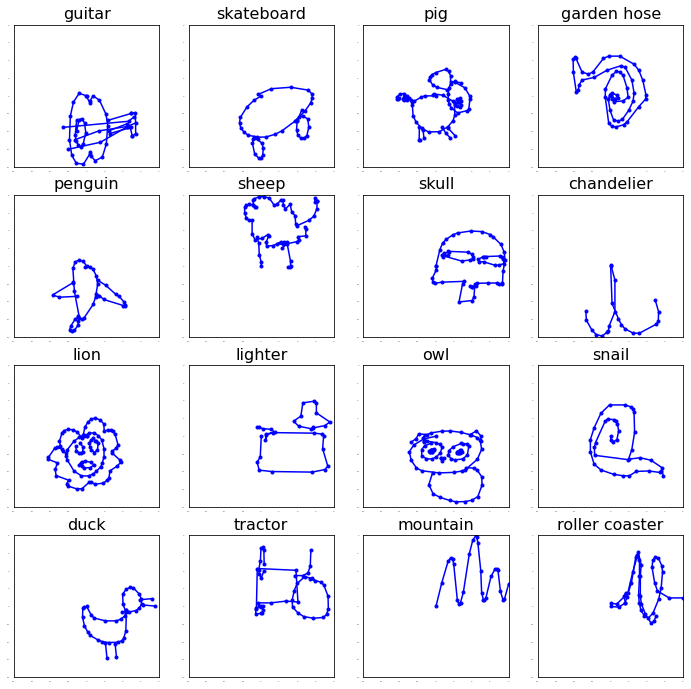

In [9]:
def draw_sketch(sample):
    class_index = sample['class_index']
    ink = sample['ink'].numpy()
    ink[:, :-1] = ink[::, :-1].cumsum(axis=0)
    split_indices = [idx for idx in range(len(ink)) if ink[idx, 2] == 1.0]
    
    lines = [np.concatenate(([[0.0, 0.0, 0.0]], ink[:split_indices[0]+1]), axis=0)]
    for start, end in zip(split_indices[:-1], split_indices[1:]):
        lines.append(ink[start+1:end+1, :])
    
    for line in lines:
        plt.plot(line[:, 0], -line[:, 1], 'b.-')
    
    plt.title(list_classes[class_index], fontsize=16)
    plt.tick_params(length=0, labelsize=0)
    plt.axis([-1.0, 1.0, -1.0, 1.0])

plt.figure(figsize=(12, 12))
for i, sample in enumerate(train_raw_ds.map(parse).take(16)):
    plt.subplot(4, 4, i+1)
    draw_sketch(sample)

# Preparing and fitting a model

We'll use a 1D convolution at the bottom of the model as a common initial processing, then standard LSTM to sequence processing:

In [10]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, 5, padding='same', activation='relu', input_shape=(None, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc'),
             keras.metrics.SparseTopKCategoricalAccuracy(name='top 5')]
)

In [11]:
history = model.fit(train_ds, epochs=2, validation_data=eval_ds)

107813/107813 [==============================] - 24784s 230ms/step - loss: 2.1838 - acc: 0.4959 - top 5: 0.7425 - val_loss: 1.4733 - val_acc: 0.6326 - val_top 5: 0.8701
Epoch 2/2
107813/107813 [==============================] - 24521s 227ms/step - loss: 1.3649 - acc: 0.6573 - top 5: 0.8838 - val_loss: 1.2932 - val_acc: 0.6745 - val_top 5: 0.8929


As expected, the accuracy looks too low and a bit misleading (roughly 1/3 of all examples are misclassified) but the top 5 accuracy looks better (89%) and, as we stated before, is more informative in the case because of big number of classes.

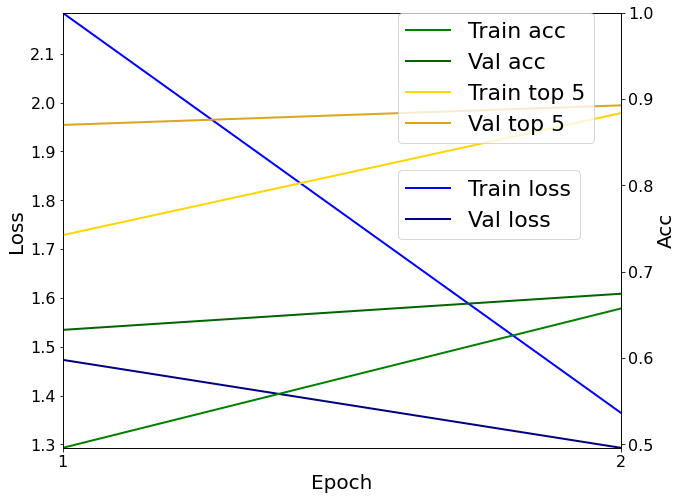

In [19]:
legend_fontsize = 22
ticks_labelsize = 16
ylabel_fontsize = 20
linewidth       = 2


train_loss  = history.history['loss']
train_acc   = history.history['acc']
train_top_5 = history.history['top 5']

val_loss    = history.history['val_loss']
val_acc     = history.history['val_acc']
val_top_5   = history.history['val_top 5']

total_epochs = len(train_loss)


fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xticks(np.arange(total_epochs))
ax.set_xticklabels(np.arange(total_epochs)+1, fontsize=ticks_labelsize)
ax.set_xlim(0, total_epochs-1)
ax.set_xlabel('Epoch', fontsize=ylabel_fontsize)

ax.plot(train_loss, color='blue', label='Train loss', linewidth=linewidth)
ax.plot(val_loss, color='navy', label='Val loss', linewidth=linewidth)
all_losess = train_loss + val_loss
ax.set_ylim(min(all_losess), max(all_losess))
ax.set_ylabel('Loss', fontsize=ylabel_fontsize)

ax2 = ax.twinx()
ax2.plot(train_acc, color='green', label='Train acc', linewidth=linewidth)
ax2.plot(val_acc, color='darkgreen', label='Val acc', linewidth=linewidth)
ax2.plot(train_top_5, color='gold', label='Train top 5', linewidth=linewidth)
ax2.plot(val_top_5, color='goldenrod', label='Val top 5', linewidth=linewidth)
all_accs = train_acc + val_acc + train_top_5 + val_top_5
ax2.set_ylim(min(all_accs), 1.0)
ax2.set_ylabel('Acc', fontsize=ylabel_fontsize)

ax.tick_params(axis='y', labelsize=ticks_labelsize)
ax2.tick_params(axis='y', labelsize=ticks_labelsize)
ax.legend(loc=(0.6, 0.48), fontsize=legend_fontsize)
ax2.legend(loc=(0.6, 0.7), fontsize=legend_fontsize)

Training and validation loss decrease during training as it should and both accuracies increase. However, the slopes of validation accuracies is low so further training probably wouldn't improve the results much.

# Difficult examples

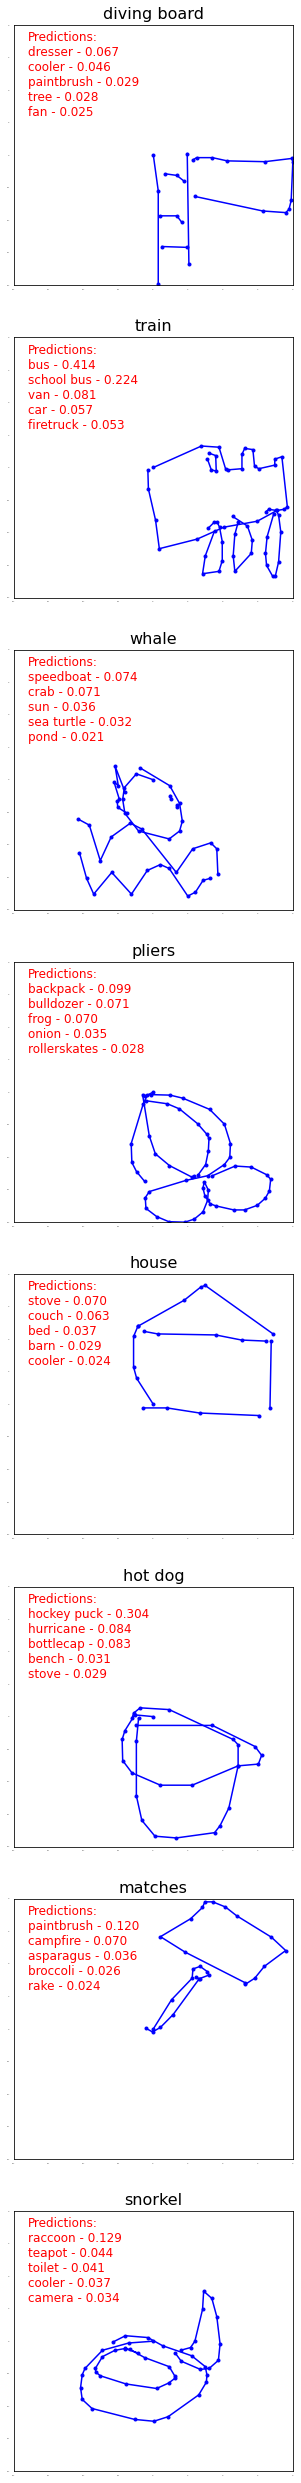

In [116]:
i = 0
tmp_ds = eval_raw_ds.map(parse)

plt.figure(figsize=(5, 45))

for sample in tmp_ds:
    predictions = model.predict(sample['ink'][np.newaxis, ...]).ravel()
    top_5_predictions = predictions.argsort(axis=None)[:-6:-1]
    if sample['class_index'] in top_5_predictions:
        continue
        
    plt.subplot(8, 1, i+1)
    draw_sketch(sample)
    pred_str = '\n'.join(f'{list_classes[prediction]} - {predictions[prediction] :4.3f}' for prediction in top_5_predictions)
    plt.text(-0.9, 0.3, f'Predictions:\n{pred_str}', color='red', fontsize=12)
    i += 1
    if i == 8:
        break

A few misclassified examples reveal interesting pattern: when the model totally lose concept of given picture, it usually produces low probabilities for many classes, meaning it's totally unsure what it is shown.